<a href="https://colab.research.google.com/github/rajivsam/interactive_tutorials/blob/master/notebooks/Graph_Retail_EDA_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

%%capture
!git clone https://github.com/rajivsam/interactive_tutorials.git
!rsync -av interactive_tutorials/notebooks/data  interactive_tutorials/notebooks/tools interactive_tutorials/notebooks/img  interactive_tutorials/notebooks/tools ./ --exclude=.git
!pip install python-arango
!pip install arangopipe==0.0.6.9.5
!pip install pandas PyYAML==5.1.1 sklearn2
!pip install jsonpickle
!pip install yellowbrick==1.1

In [2]:
! chmod a+x tools/* 

In [3]:
! wc -l data/user_item_utility_matrix.csv

480 data/user_item_utility_matrix.csv


# Overview
This notebook is the second notebook of the series that applies graph analytics to extract insights from a real world retail dataset. The previous notebook performed exploratory data analysis and created a user-item-utility representation of the frequent customers to store. This data representation of the store customer is inherently high dimensional. In this notebook, a feature selection method is applied to reduce the dimensionality of the customer representation. The __RFM__ concept discussed briefly in the previous notebook, discussed in more detail here, is used to perform feature selection. The details are provided below.

   ## Customer Value using Recency-Frequency-Monetary(RFM) value metric 

The RFM idea is commonly used in retail to perform [customer segmentation](https://thegood.com/insights/rfm-analysis-convert/).In this work, we will use the RFM value for feature selection. To begin with, rather than consider all three attributes, we will compute an RFM score as a weighted combination of the customers recency, frequency and monetary value attributes. The $RFM\_score$ for a customer, $c$, is computed as:
\begin{equation*}
RFM\_score_{c} = weight_{frequency} . frequency_c + weight_{recency}. frequency_c + weight_{monetary value} monetary\_value_c
\label{eq:rfm_score_full_defn} \tag{1}
\end{equation*}



Recall that the customer, $c$, is represented in terms of the items he or she has purchased at the store. There are $2505$ items in the inventory purchased by the frequent shopper group. The purpose of this notebook is to apply a feature selection algorithm to reduce this high dimensional representation to a more tractable one. We will illustrate that most of the customer value in the store is associated with a small set of store inventory items. We will posit a linear relationship between the $RFM\_score$ for a customer and their store purchases,i.e., 
 
\begin{equation*}
  RFM\_score_c = \sum_{i=1}^{i=d} s_{ci} \beta_i
\label{eq:sum_lasso} \tag{2}
\end{equation*}

Here $s_{ci}$ indicates the amount spent by customer, $c$, on item, $i$, at the store. The $\beta_i$ are model coefficients.  Later in this work, we will evaluate if assuming such a linear model between the $RFM\_score$ and the customer purchases is reasonable. In this work, we will add other constraints to this linear relationship. In particular, we will use an idea called _regularization_ with the model. In a conventional linear model, the coefficients, $\beta_i$, are determined by minimizing the error between the model estimates and the actual observed value. In a _regularized_ model, an additional constraint is placed, we want to make these coefficients as small as possible, driving them to a zero value, if possible. The __Least Angle Shrinkage Selector__ [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics)) is a popular and effective linear model with this regularization feature. The interested reader may consult [Statistical Learning with Sparsity](https://web.stanford.edu/~hastie/StatLearnSparsity_files/SLS_corrected_1.4.16.pdf) for the details of the LASSO . Expressed as matrices, the model we are using here is:

\begin{equation*}
 RFM\_score = \mathbf{S}.\mathbf{\beta}
\label{eq:matrix_lasso} \tag{3}
\end{equation*}

where:

$RFM\_score$, is a $N \times 1$ matrix of computed RFM scores,

$\mathbf{S}$, is a $N \times d$ matrix of customer spend on items,

$\mathbf{\beta}$, is a $d \times 1$ matrix of model coefficients.

The LASSO minimizes the following objective to determine the best linear model:
\begin{equation*}
 min_{\beta \in \mathcal{R}^d} \left\{\frac{1}{N} \left\| RFM\_score - \mathbf{s}\mathbf{\beta} \right\|^2  + \lambda \left\|\mathbf{\beta}\right\|_1 \right\} 
\label{eq:obj_lasso} \tag{4}
\end{equation*}


There are $2505$ inventory items for this group and there are $618$ customers in the frequent shopper group. So $d=2505,\ N= 618$, in the above equation. An examination of the above objective shows that applying LASSO to estimate a linear model requires the selection of the regularization parameter $\lambda$. Once this parameter is selected, the LASSO solution can be computed. After computing the LASSO solution, the model coefficients, $\beta$ are known. Since we are using LASSO for feature selection, we need to determine how many features we want to select from the model. As we will illustrate, a small proportion of these coefficients account for most of the customer value. We will use an experiment to determine the optimal number of features to extract for this dataset. We will use cross-validation to determine the optimal value of the regularization parameter, $\lambda$. We will then evaluate if our assumption about using a linear model for customer value, for the purposes of feature selection, is a reasonable one. Before the linear model can be applied to the data, there is an important pre-processing step. An evaluation of the distribution of the $RFM\_score$ shows a skewed, non-normal distribution. Linear models work well when the response is _Normally_ distributed. _Since $RFM\_score$ is an engineered attribute, we might as well take an additional step and transform it to form that is known to be a desirable characteristic_. This additional step is the transformation of the $RFM\_score$ that makes it normally distributed. A [__Box-Cox__](https://en.wikipedia.org/wiki/Power_transform) transoformation is used to transform the $RFM\_score$ to one that has a normal distribution. 

 The workflow for this notebook is shown below ![workflow](https://github.com/rajivsam/interactive_tutorials/blob/master/notebooks/img/feature_selection_overview.png?raw=1)

The rest of this notebook, provides an implementation of this workflow.

## Read the User-Item-Utility-Matrix

The input data file for this notebook is the user-item-utility matrix that was created at the end of the notebook implementing the first phase of this series. The following block, reads the matrix and identifies the data blocks corresponding to the predictor variables, the $\mathbf{S}$ matrix and the raw __RFM__ values.

In [4]:
import pandas as pd
import numpy as np
fp = "data/user_item_utility_matrix.csv"
df = pd.read_csv(fp)
df_u = df["Customer ID"]
col_y = ["MonetaryValue", "freq", "recency"] 
cols = df.columns.tolist()
col_exclude = ["MonetaryValue", "freq", "recency", "Customer ID"]
col_x = [ c for c in cols if c not in col_exclude]
df_y = df[col_y]
df_x = df[col_x] # This is the S matrix


### Standardize the Spend Matrix 
The columns of the customer spend matrix are standardized. This removes the mean and transforms all variables to unit variance.

In [5]:
from sklearn import preprocessing
x = df_y.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
df_y = pd.DataFrame(x_scaled)
df_y.columns = col_y

### Compute the $RFM\_score$ Attribute
For this exercise, a weight of $0.7$ is used for monetary value, a weight of $0.15$ was used for recency and frequency. This is user specified. Equation (1) is used to calculate the $RFM\_score$ attribute. For this exercise, the monetary value is primary consideration in determining the __value__ of the customer. The computed $RFM\_score$ is then plotted.

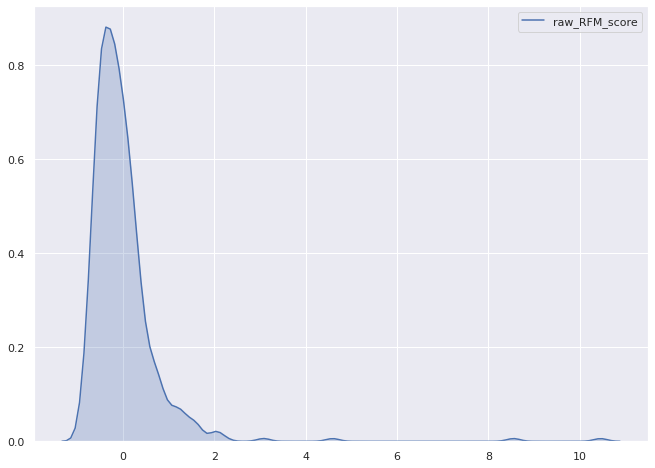

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
weights = {'wt_mv':0.7, 'wt_freq': 0.15, 'wt_rec': 0.15}
def assign_raw_RFM_score(row):
    score = weights['wt_mv']*row["MonetaryValue"] + \
    weights["wt_freq"] * row["freq"] + weights["wt_rec"]*  row["recency"]
    return score
df_y['raw_RFM_score'] = df_y.apply(func = assign_raw_RFM_score, axis = 1)

plt.rcParams['figure.figsize'] = [11, 8]
sns.set(color_codes=True)
sns.kdeplot(df_y["raw_RFM_score"], shade = True)

### Observation
Observe that the distribution of $RFM\_score$ attribute is _skewed_ and does not resemble the _bell_ shaped curve of the _Normal_ distribution.

### Summarize the RFM attributes

In [7]:
df_y = df[col_y]
df_y.describe()

,MonetaryValue,freq,recency
count,479.000000,479.000000,479.000000
mean,1976.460418,8.797495,0.094964
std,1695.791200,10.179493,0.167148
min,70.020000,5.000000,0.001499
25%,1080.005000,5.000000,0.017184
50%,1665.420000,7.000000,0.038288
75%,2404.905000,9.000000,0.078811
max,24082.620000,172.000000,1.000000


### Apply the Box-Cox Transformation to $RFM\_score$

Apply the Box-Cox transformation to the $RFM\_score$ attribute and plot the distribution of the transformed attribute.

In [8]:
from sklearn.preprocessing import power_transform
trans_y = power_transform(df_y, method='box-cox', standardize=False)

In [9]:
df_trans_y = pd.DataFrame(trans_y)
df_trans_y.columns = ["bc_MV", "bc_freq", "bc_recency"]
weights = {'wt_mv':0.7, 'wt_freq': 0.15, 'wt_rec': 0.15}
def assign_RFM_score(row):
    score = weights['wt_mv']*row["bc_MV"] + \
    weights["wt_freq"] * row["bc_freq"] + weights["wt_rec"]*  row["bc_recency"]
    return score
df_trans_y['RFM_score'] = df_trans_y.apply(func = assign_RFM_score, axis = 1)

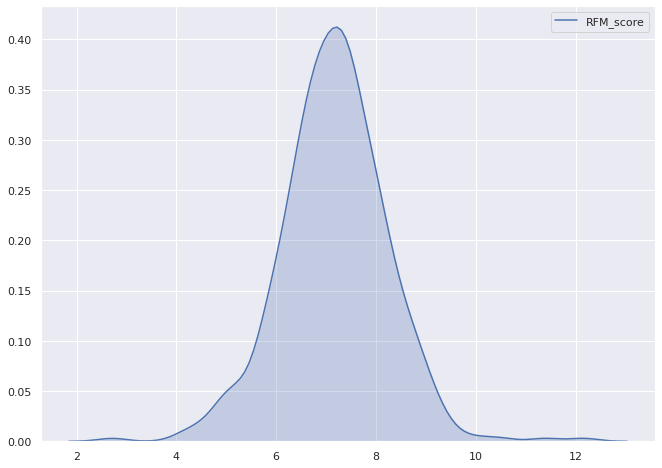

In [10]:
plt.rcParams['figure.figsize'] = [11, 8]
sns.set(color_codes=True)
sns.kdeplot(df_trans_y["RFM_score"], shade = True)

### Observation
The distribution of the Box-Cox transformed $RFM\_score$ looks the familiar bell shaped curve of the _Normal_ distribution. A standard way to verify if a variable has a particular distribution is to plot the quantiles of the variable versus the quantiles of the distribution we are comparing against (with the mean and variance of the variable that we want to compare, here it is the $RFM\_score$). If the variable has the behavior of the target distribution, then the quantile-qauntile plot will be a straight line. 

### Probability plot of transformed $RFM\_score$

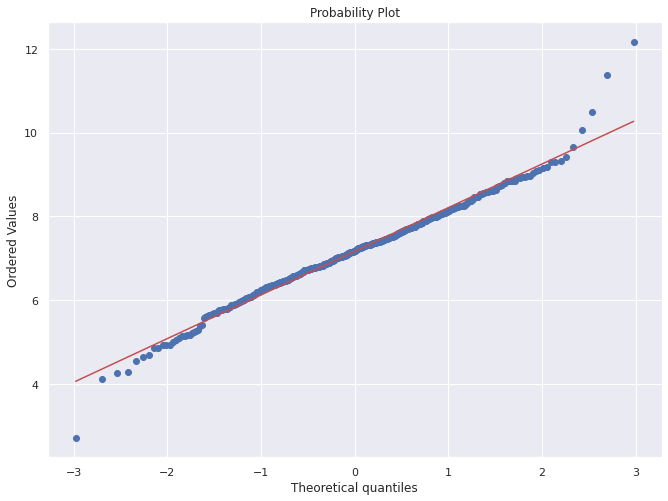

In [11]:
import scipy.stats as stats
stats.probplot(df_trans_y["RFM_score"], dist="norm", plot = plt)
plt.show()

### Create Test and Training datasets
Generalization is a key consideration in determining the appropriate number of features to select. To evaluate generalization, we need a test set. Accordingly, two-thirds of the dataset is used for training and one-third is set aside to evaluate generalization. The following block creates the test and training datasets for this notebook.

In [12]:
X = df_x.values
Y = df_trans_y['RFM_score'].values
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
TRNG_SIZE = X_train.shape[0]
TEST_SIZE = X_test.shape[0]

### Determine the best value of $\lambda$, the regularization parameter for the LASSO

The [yellow brick](https://www.scikit-yb.org/en/latest/) library is used to determine the best value of the regularization parameter $\lambda$, see Equation(4). The [scikit-learn](https://scikit-learn.org/)implementation of the LASSO algorithm is used in this work. The $\lambda$ selection is performed using the training dataset we created in the previous step. [Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) is used to select the best value of $\lambda$ for this dataset. The LASSO implementation minimizes the objective discussed in the overview section, Equation (4), and drives the model coefficients, $\mathbf{\beta}$, to zero if possible.

/home/admin2/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


           Metric  Value
0    Training MSE  0.153
1        Test MSE  0.459
2  Training $R^2$  0.849
3      Test $R^2$  0.637


/home/admin2/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


AlphaSelection(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e848e7f90>,
               is_fitted='auto', model=None)

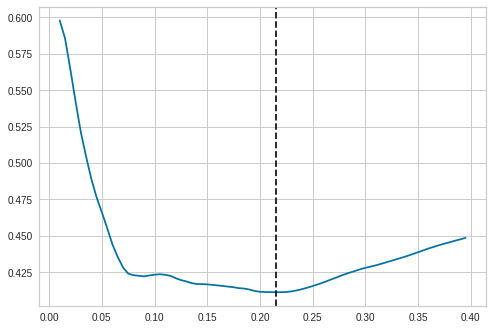

In [13]:
from yellowbrick.regressor import AlphaSelection
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
Xexp = X_train
Yexp = Y_train
Xtexp = X_test
Ytexp = Y_test
alphas = np.arange(0.01, 0.4, 0.005)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

#reg_exp = ElasticNetCV(alphas = alphas, cv = kfold, max_iter=10000)
reg_exp = LassoCV(alphas = alphas, cv = kfold, max_iter=10000)

reg_exp.fit(Xexp, Yexp.ravel())
exp_score = reg_exp.score(Xexp, Yexp)
y_trng_pred = reg_exp.predict(Xexp)
y_test_pred = reg_exp.predict(Xtexp)
trng_fit_score = "%0.3f"%reg_exp.score(Xexp, Yexp)
test_fit_score = "%0.3f"%reg_exp.score(Xtexp, Ytexp)
e_trng_mse = "%0.3f"%mean_squared_error(Yexp, y_trng_pred)
e_test_mse = "%0.3f"%mean_squared_error(Ytexp,y_test_pred)

fes = {"Training MSE": e_trng_mse,
       "Test MSE": e_test_mse,
       "Training $R^2$": trng_fit_score,
       "Test $R^2$": test_fit_score}
df_fes = pd.DataFrame(fes.items())
df_fes.columns = ["Metric", "Value"]
print(df_fes)
visualizer = AlphaSelection(reg_exp)
visualizer.fit(Xexp, Yexp)


### Observation:
The best value of $\lambda$ is about $0.35$. At this value, the lowest cross-validation error is observed. This value will be used with the LASSO for feature selection. The solution from the LASSO provides the model coefficients, $\mathbf{\beta}$. Since we are working with a linear model, the magnitude of the coefficient is a direct indication of a particular item towards explaining the customer $RFM\_score$. So an ordering of the $\mathbf{\beta}$ in descending order gives the feature importance. That brings us to the question of the number of features we want to select. To determine the number of features, we design the following experiment. We order the features by sorting them in descending order. Starting with the most important feature, we develop a linear model and then observe the test set error with included features. We then add the next most imporant feature and then observe the test error. We repeat this process. We incrementally add all the features and plot the number of features versus the observed test error.

In [14]:
ord_indices = reg_exp.coef_.ravel().argsort()[::-1]
num_features = np.arange(2,125, 2)
from sklearn.linear_model import LinearRegression
trng_err = []
test_err = []
for nf in num_features:
    Xtrngexp = X_train[:, ord_indices[:nf]]
    Xtestexp = X_test[:, ord_indices[:nf]]
    Ytrngexp = Y_train
    Ytestexp = Y_test
    rfsm = LinearRegression()
    rfsm.fit(Xtrngexp, Ytrngexp.ravel())
    y_trng_pred = rfsm.predict(Xtrngexp)
    y_test_pred = rfsm.predict(Xtestexp)
    trngmse = round(mean_squared_error(Y_train, y_trng_pred), 3)
    testmse = round(mean_squared_error(Y_test, y_test_pred), 3)
    trng_err.append(trngmse)
    test_err.append(testmse)
    gap_ratio = float(trngmse)/float(testmse)
    #print('for {} features, training error is {}, test error is {}'.format(nf, trngmse, testmse))
    #print('for {} features, gap_ratio is {:.3f}, training error is {}, test err is {}'.format(nf, gap_ratio, trngmse, testmse))
    

## Observation
1. The first $50$ or so features explain most of the variablity in the $RFM\_score$.
2. Increasing the number of features beyond $75$ features does not reduce the test error. There is no benefit in adding more features to the model because this does not yield a generalizable model performance. Therefore, the optimal number of features to select for this data is $75$.

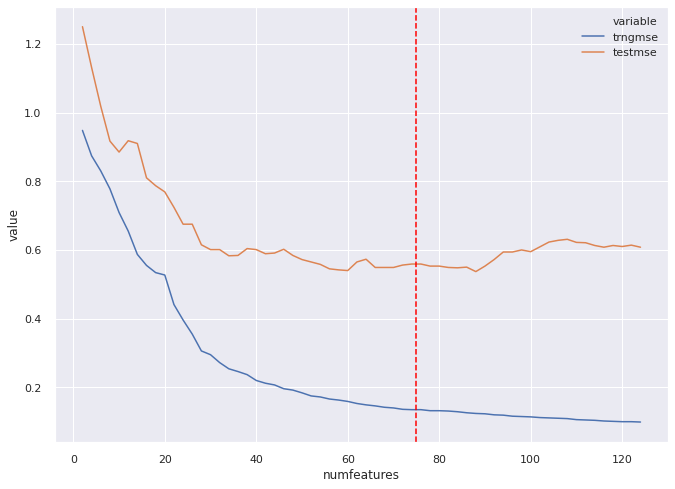

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
NUM_FEATURES_OPT = 75
aed = {"numfeatures": num_features, "trngmse": trng_err, "testmse": test_err}
df_nf_sel = pd.DataFrame(aed)
cols_to_plot = ["numfeatures", "trngmse", "testmse"]
df_plot = df_nf_sel[cols_to_plot]
df_ep = df_plot.melt(id_vars = ['numfeatures'])
df_ep["value"] = df_ep["value"].astype(np.float)

plt.rcParams['figure.figsize'] = [11, 8]
sns.set(color_codes=True)
sns.lineplot(x='numfeatures', y='value', hue='variable', data = df_ep)
plt.axvline(x = NUM_FEATURES_OPT, color ='red', linestyle= '--') 

In [16]:
ord_indices = reg_exp.coef_.ravel().argsort()[::-1]
OPT_NUM_FEATURES = 75

Xtrngexp = X_train[:, ord_indices[:OPT_NUM_FEATURES]]
Xtestexp = X_test[:, ord_indices[:OPT_NUM_FEATURES]]
Ytrngexp = Y_train
Ytestexp = Y_test
rfsm = LinearRegression()
rfsm.fit(Xtrngexp, Ytrngexp.ravel())
y_trng_pred = rfsm.predict(Xtrngexp)
y_test_pred = rfsm.predict(Xtestexp)
trngmse = round(mean_squared_error(Y_train, y_trng_pred), 3)
testmse = round(mean_squared_error(Y_test, y_test_pred), 3)

## Is the assumption of a linear relationship between customer spend and the transformed $RFM\_score$ valid?

To verify if the assumption of a linear relationship between the $RFM\_score$ and the customer spend, we can plot the values predicted by such a linear model versus the true $RFM\_score$ on the test set. If the model is reasonable, then we should expect agreement or similar values for the model prediction and the ground truth. If we plot the predicted versus the actual values, we should see a straight line. This is what we observe.

Text(0.5, 1.0, 'Actual vs Fitted Values (test set)')

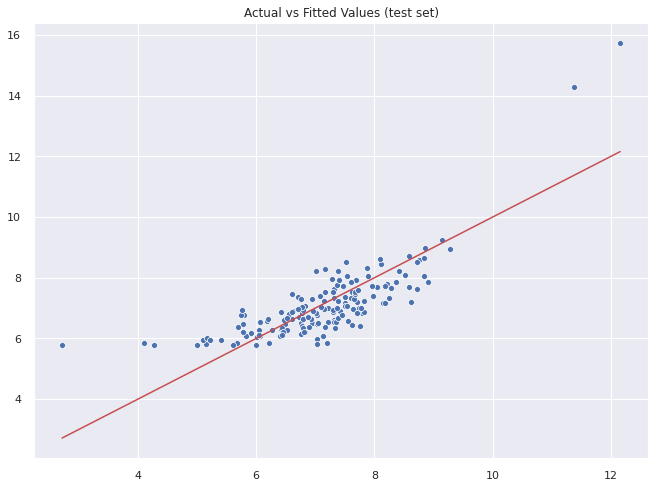

In [17]:
plt.rcParams['figure.figsize'] = [11, 8]
sns.set(color_codes=True)
xp = np.linspace(Ytestexp.ravel().min(), Ytestexp.ravel().max(), 30)
yp = xp
g = sns.scatterplot(x=Ytestexp.ravel(), y=y_test_pred.ravel())
plt.plot(xp, yp, color='r')
plt.title("Actual vs Fitted Values (test set)")

### Observation:
A plot of the predicted versus actual shows reasonable agreement. Perfect agreement is the red line. The difference between the model prediction and the actual value is the _error_ . We will evaluate the nature of this _error_ shortly.

In [18]:
feats = col_x
if "Customer ID" in feats:
    feats.remove("Customer ID")
feats = np.array(feats)
bm_ord_ind = reg_exp.coef_.ravel().argsort()[::-1]
feats = feats.ravel()[bm_ord_ind][:NUM_FEATURES_OPT]
bmcoefs = reg_exp.coef_.ravel()[bm_ord_ind][:NUM_FEATURES_OPT]

### Examine the Error
A density plot of the error provides information about the distribution of its values. A _probability-probablity_ plot of the error with normal distribution tells us if it is reasonable to approximate the errors as being _normal_.

In [19]:
test_err = y_test_pred - Ytestexp

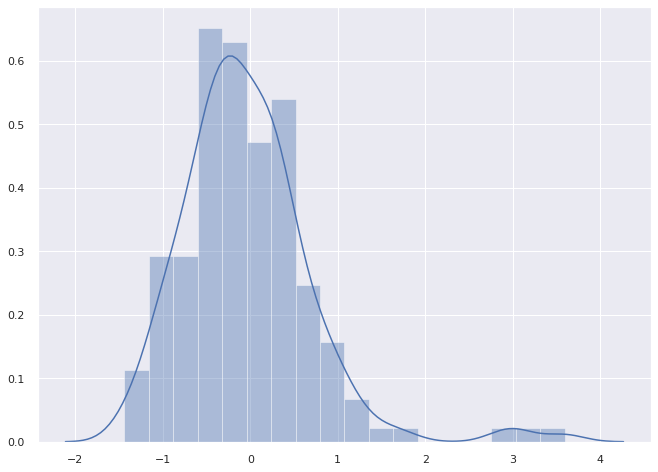

In [20]:
plt.rcParams['figure.figsize'] = [11, 8]
sns.set(color_codes=True)
sns.distplot(test_err)

## Outliers

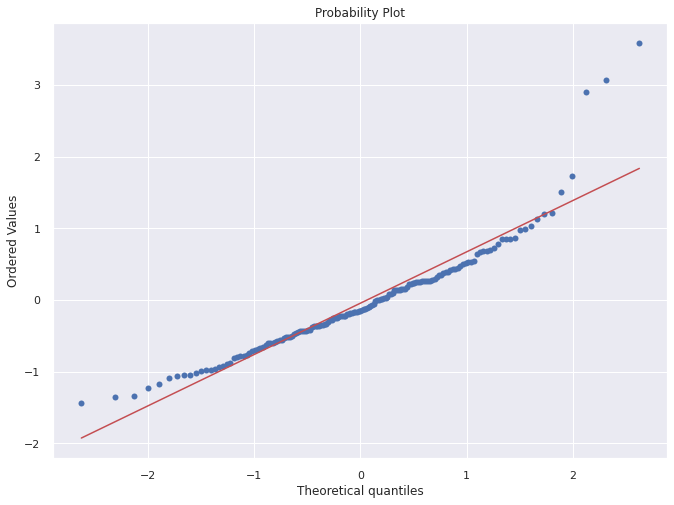

In [21]:
stats.probplot(test_err, dist="norm", plot = plt)
plt.show()

### Observation
1. An evaluation of the density plot shows that we have a small number of points where the error is large.
2. On the probability-probability plot, these points show up as those being greater than 3 standard deviations (top right corner of the plot above)

These points are _outliers_. See any standard reference or resource on linear regression, for example,[this reource](https://online.stat.psu.edu/stat462/node/173/) for a more detailed understanding of outliers. The _Cook's Distance_ will be used to remove this problematic points from the dataset. We will then redo the linear model and check the distribution of errors. If the outliers have been removed, the errors from the model should be within 3 standard deviations. The _yellowbrick_ library comes with an implementation that we can use for this purpose. The details are shown below. 

In [22]:
Xfs = X[:, bm_ord_ind[:NUM_FEATURES_OPT]]
Yfs = Y

## Remove the Outliers

/home/admin2/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/admin2/anaconda3/lib/python3.7/site-packages/yellowbrick/regressor/influence.py:183: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  self.distance_, linefmt=self.linefmt, markerfmt=self.markerfmt


CooksDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e85bb6a50>,
              draw_threshold=True, linefmt='C0-', markerfmt=',')

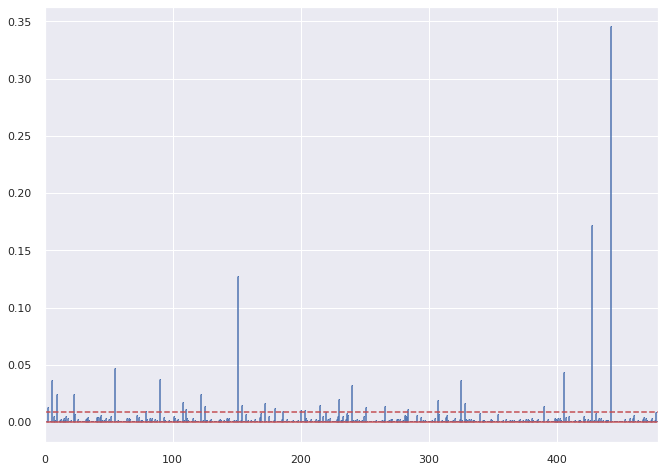

In [23]:
from yellowbrick.regressor import CooksDistance
visualizer = CooksDistance()
visualizer.fit(Xfs, Yfs)



In [24]:
i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
X_li, Y_li = Xfs[i_less_influential], Yfs[i_less_influential]
customers = df_u.values[i_less_influential]

## Verify Model after Outlier Removal

__We develop the linear model and verify it again after outlier removal__.

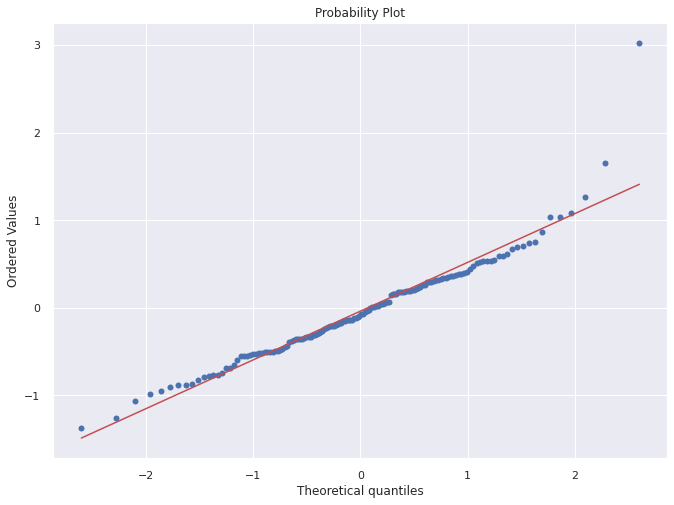

In [25]:
X = X_li
Y = Y_li
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
TRNG_SIZE = X_train.shape[0]
TEST_SIZE = X_test.shape[0]
rfsm = LinearRegression()
rfsm.fit(X_train, Y_train.ravel())
y_trng_pred = rfsm.predict(X_train)
y_test_pred = rfsm.predict(X_test)
trngmse = round(mean_squared_error(Y_train, y_trng_pred), 3)
testmse = round(mean_squared_error(Y_test, y_test_pred), 3)
test_err = y_test_pred - Y_test
stats.probplot(test_err, dist="norm", plot = plt)
plt.show()

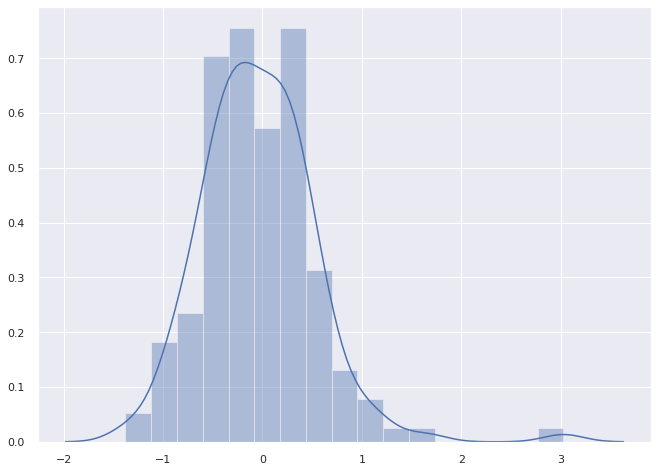

In [26]:
plt.rcParams['figure.figsize'] = [11, 8]
sns.set(color_codes=True)
sns.distplot(test_err)

### Observation
_An evaluation of the errors after outlier removal shows that the errors from the model are within 3 standard deviations. So the outliers have been removed and the model has been validated!_


## Plot Feature Importance for the Frequent Shopper Group

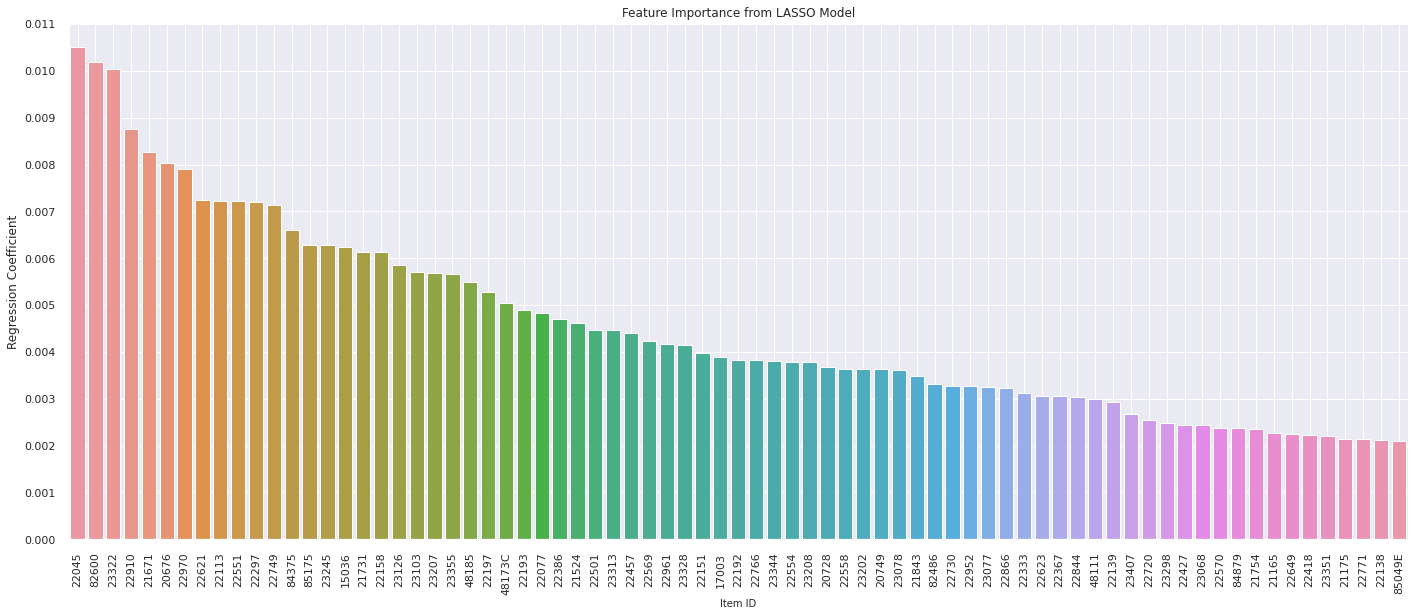

In [27]:
import matplotlib.ticker as ticker
plt.rcParams['figure.figsize'] = [24, 9.5]
plt.rcParams['xtick.labelsize'] = 'xx-small'
sns.set(color_codes=True)
g = sns.barplot(x = feats, y = bmcoefs, ci = None)
plt.title("Feature Importance from LASSO Model")
plt.grid(True)
plt.xlabel('Item ID', fontsize=10)
plt.ylabel('Regression Coefficient')
plt.locator_params(axis='y', nbins=20)
l = g.set_xticklabels(feats, rotation=90)

## Feature Selection Done !!!


We have now reduced the dataset to a dataset with 447 users and 75 items. The customers's purchases of items can be modeled as a bi-partite graph. In this graph, customers and the items are the vertex collections. The purchases are edges from the customer to the items and edge weight is the spend of the customer on that item. We now:
1. Capture the meta-data about the analysis done in this notebook and record it in the Arangopipe project we created in the previous notebook. We will use the same database we used in the previous notebook.
2. The data after feature selection can be modeled as a [__bi-partite__ graph ](https://en.wikipedia.org/wiki/Bipartite_graph#:~:text=In%20the%20mathematical%20field%20of,the%20parts%20of%20the%20graph.) with the customers and items being the two vertex sets. This __bi-partite graph__ is the graph that we have learned from the raw dataset, after feature selection. This graph is written out to ArangoDB.

## Write the Retail Graph to ArangoDB

In [28]:
from arangopipe.arangopipe_storage.arangopipe_api import ArangoPipe
from arangopipe.arangopipe_storage.arangopipe_admin_api import ArangoPipeAdmin
from arangopipe.arangopipe_storage.arangopipe_config import ArangoPipeConfig
from arangopipe.arangopipe_storage.managed_service_conn_parameters import ManagedServiceConnParam
mdb_config = ArangoPipeConfig()
msc = ManagedServiceConnParam()
conn_params = { msc.DB_SERVICE_HOST : "arangoml.arangodb.cloud", \
                        msc.DB_SERVICE_END_POINT : "createDB",\
                        msc.DB_SERVICE_NAME : "createDB",\
                        msc.DB_SERVICE_PORT : 8529,\
                        msc.DB_CONN_PROTOCOL : 'https',\
                        msc.DB_REPLICATION_FACTOR: 3}
        
mdb_config = mdb_config.create_connection_config(conn_params)
admin = ArangoPipeAdmin(reuse_connection = False, config = mdb_config)
ap_config = admin.get_config()
ap = ArangoPipe(config = ap_config)
proj_info = {"name": "Retail_Graph_Analytics"}
proj_reg = admin.register_project(proj_info)
mdb_config.get_cfg()

API endpoint: https://arangoml.arangodb.cloud:8529/_db/_system/createDB/createDB


/home/admin2/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Host Connection: https://arangoml.arangodb.cloud:8529


{'arangodb': {'DB_service_host': 'arangoml.arangodb.cloud',
  'DB_end_point': 'createDB',
  'DB_service_name': 'createDB',
  'DB_service_port': 8529,
  'conn_protocol': 'https',
  'arangodb_replication_factor': 3,
  'dbName': 'MLlsy9bo5km1qveu1018894',
  'username': 'MLaiirpg2oif28s5lodekbp',
  'password': 'ML84osxggmrkmvxjoigfh2'},
 'mlgraph': {'graphname': 'enterprise_ml_graph'}}

In [29]:
login = mdb_config.get_cfg()['arangodb']

In [30]:
# Restore an ArangoDB dump into the database.
!./tools/arangorestore  -c none --server.endpoint  http+ssl://{login["DB_service_host"]}:{login["DB_service_port"]} --server.username {login["username"]} \
--server.database {login["dbName"]} \
--server.password {login["password"]} \
--replication-factor 3  \
--input-directory "data/retail_freq_cust_data_dump_eonb1"

2021-06-17T08:29:30Z [115464] INFO [05c30] {restore} Connected to ArangoDB 'http+ssl://arangoml.arangodb.cloud:8529'
2021-06-17T08:29:33Z [115464] INFO [abeb4] {restore} Database name in source dump is 'MLczv8x2yt3249phe038k6fi'
2021-06-17T08:29:33Z [115464] INFO [9b414] {restore} # Re-creating document collection 'datasets'...
2021-06-17T08:29:33Z [115464] INFO [9b414] {restore} # Re-creating document collection 'deployment'...
2021-06-17T08:29:34Z [115464] INFO [9b414] {restore} # Re-creating document collection 'devperf'...
2021-06-17T08:29:35Z [115464] INFO [9b414] {restore} # Re-creating document collection 'featuresets'...
2021-06-17T08:29:35Z [115464] INFO [9b414] {restore} # Re-creating document collection 'modelparams'...
2021-06-17T08:29:36Z [115464] INFO [9b414] {restore} # Re-creating document collection 'models'...
2021-06-17T08:29:36Z [115464] INFO [9b414] {restore} # Re-creating document collection 'project'...
2021-06-17T08:29:37Z [115464] INFO [9b414] {restore} # Re-cr

In [31]:
tut_db = admin.db

In [32]:
if not tut_db.has_graph("retail_freq_cust_graph"):
    tut_db.create_graph('retail_freq_cust_graph')

In [33]:
rf = mdb_config.cfg['arangodb']['arangodb_replication_factor']

In [34]:
rf = mdb_config.cfg['arangodb']['arangodb_replication_factor']
retail_freq_cust_graph = tut_db.graph("retail_freq_cust_graph")

if not tut_db.has_collection("Customers"):
    tut_db.create_collection("Customers", rf)
if not tut_db.has_collection("Items"):
    tut_db.create_collection("Items", rf)
if not tut_db.has_collection("Purchases"):
    tut_db.create_collection("Purchases", rf, edge=True)
if not retail_freq_cust_graph.has_edge_definition("Purchases"):
    purchases = retail_freq_cust_graph.create_edge_definition(
        edge_collection='Purchases',
        from_vertex_collections=['Customers'],
        to_vertex_collections=['Items']
    )

In [35]:
import json
%time


num_freq_cust = X.shape[0]
batch = []
BATCH_SIZE = 100
batch_idx = 1
collection =tut_db["Customers"]

for cidx in range(num_freq_cust):
  pk = "Customers/" + str(customers[cidx])
  insert_doc1 = {"_id": pk}
  batch.append(insert_doc1)
  
  if len(batch) == BATCH_SIZE:
    print("Inserting batch %d" % (batch_idx))
    collection.import_bulk(batch, on_duplicate = 'replace')
    batch = []
    batch_idx += 1
  
  last_record = (cidx == (num_freq_cust -1) )
    
  if last_record and len(batch) > 0:
    print("Inserting batch the last batch!")
    collection.import_bulk(batch, on_duplicate = 'replace')

CPU times: user 10 µs, sys: 1 µs, total: 11 µs
Wall time: 19.3 µs
Inserting batch 1
Inserting batch 2
Inserting batch 3
Inserting batch 4
Inserting batch the last batch!


In [36]:
pk

'Customers/18283'

In [37]:
import json
%time
num_features = len(feats)
collection = tut_db["Items"]
batch = []
for fidx in range(num_features):
  pk = "Items/" + str(feats[fidx])
  insert_doc1 = {"_id": pk}
  batch.append(insert_doc1)


  collection.import_bulk(batch, on_duplicate = 'replace')


CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.2 µs


In [38]:
import json
%time


num_freq_cust = X.shape[0]
num_features = X.shape[1]
batch = []
BATCH_SIZE = 500
batch_idx = 1
collection =tut_db["Purchases"]

for cidx in range(num_freq_cust):
    
    
    for fidx in range(num_features):
        Xci = X[cidx, fidx]
        #print("Processing user: %s , item %s, value: %.3f" %(str(customers[cidx]), feats[fidx], Xci))
        if Xci > 0:
            fk = "Customers/" + str(customers[cidx])
            tk = "Items/" + feats[fidx]
            insert_doc1 = {"_from": fk, "_to": tk, "spend": str(Xci)}
            batch.append(insert_doc1)
                
            
            if len(batch) == BATCH_SIZE:
                print("Inserting batch %d" % (batch_idx))
                collection.import_bulk(batch, on_duplicate = 'replace')
                batch = []
                batch_idx += 1
        last_record = (cidx == (num_freq_cust -1) )
    
    if last_record and len(batch) > 0:
                print("Inserting batch the last batch!")
                collection.import_bulk(batch, on_duplicate = 'replace')


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
Inserting batch 1
Inserting batch 2
Inserting batch 3
Inserting batch 4
Inserting batch 5
Inserting batch 6
Inserting batch 7
Inserting batch 8
Inserting batch the last batch!


## Use Arangopipe to Log Project Activity for Feature Selection

In [39]:
ap_config = admin.get_config()
ap = ArangoPipe(config = ap_config)

## Lookup Dataset

In [40]:
ds_info = ap.lookup_dataset("retail analytics dataset")


## Lookup Featureset

In [41]:
fs_info = ap.lookup_featureset("retail analytics feature setl")

## Register Feature Selection Task with Arangopipe

In [42]:
import uuid
rtoken = str(uuid.uuid4().int)
model_info = {"name": "Feature Selection Task" + "_" + rtoken,  "task": "Feature Selection"}
model_reg = ap.register_model(model_info, project = "Retail_Graph_Analytics")

## Log Feature Selection Task with Arangopipe

In [43]:

import datetime
import jsonpickle

ruuid = str(uuid.uuid4().int)
model_perf = {'run_id': ruuid, 'training_MSE': str(trngmse),\
              'test_MSE': str(testmse), "timestamp": str(datetime.datetime.now())}

model_params = {'run_id': ruuid, 'lambda': '0.215', 'opt_features': '75'}

run_info = {"dataset" : ds_info["_key"],\
                    "featureset": fs_info["_key"],\
                    "run_id": ruuid,\
                    "model": model_reg["_key"],\
                    "model-params": model_params,\
                    "model-perf": model_perf,\
                    "tag": "Retail_Graph_Analytics",\
                    "project": "Retail_Graph_Analytics"}
ap.log_run(run_info)

In [44]:

!./tools/arangodump  -c none --server.endpoint http+ssl://{login["DB_service_host"]}:{login["DB_service_port"]} --server.username {login["username"]} --server.database {login["dbName"]} --server.password {login["password"]} --overwrite true --output-directory "data/retail_freq_cust_data_dump_eonb2"

2021-06-17T08:30:24Z [115683] INFO [f3a1f] {dump} Connected to ArangoDB 'http+ssl://arangoml.arangodb.cloud:8529', database: 'MLlsy9bo5km1qveu1018894', username: 'MLaiirpg2oif28s5lodekbp'
2021-06-17T08:30:24Z [115683] INFO [5e989] {dump} Writing dump to output directory 'data/retail_freq_cust_data_dump_eonb2' with 2 thread(s)
2021-06-17T08:30:25Z [115683] INFO [e4134] {dump} Last tick provided by server is: 685140142
2021-06-17T08:30:25Z [115683] INFO [5239e] {dump} # Dumping collection 'Purchases'...
2021-06-17T08:30:25Z [115683] INFO [5239e] {dump} # Dumping collection 'Customers'...
2021-06-17T08:30:25Z [115683] INFO [a27be] {dump} # Dumping shard 's660924351' from DBserver 'PRMR-jjwozseb' ...
2021-06-17T08:30:25Z [115683] INFO [a27be] {dump} # Dumping shard 's660924355' from DBserver 'PRMR-jjwozseb' ...
2021-06-17T08:30:26Z [115683] INFO [5239e] {dump} # Dumping collection 'run_featuresets'...
2021-06-17T08:30:26Z [115683] INFO [a27be] {dump} # Dumping shard 's660924343' from DBser

In [45]:
#Xfs = X[:, bm_ord_ind[:NUM_FEATURES_OPT]]
Yfs = Y
df_fs = pd.DataFrame(X)
df_fs.columns = feats
df_fs["RFM_score"] = Y
df_fs["Customer_ID"] = df_u
df_fs = df_fs.set_index("Customer_ID")
fp = "data/feature_selected_freq_shoppers.csv"
df_fs.to_csv(fp)

In [46]:
df_fs.shape

(447, 76)